### 생성적 적대 신경망(Generative Adversarial Networks)

- GAN은 딥러닝의 우너리를 활용해서 가상의 이미지를 생성하는 알고리즘이다.
- 즉 딥러닝 알고리즘이 **이미지 픽셀들이 어떻게 조합되어야 하는지**를 예측한 결과를 도출해 우리가 원하는 이미지를 출력하는 것이다.
- 진짜 같은 가짜를 만들기 위해서 GAN알고리즘 내부에서는 '적대적인' 경합을 진행한다.

**구성**
1. Generator(생성자)  
    - 가짜를 만들어내는 부분
2. Discriminator(판별자)
    - 진위를 가려내는 부분

#### 1. 생성자
- 어렵게 생각할 것 없이, 이과정도 결국에는 학습을 반복하면서 완전한 이미지의 픽셀값을 찾게 되는 것이다.
- 처음에는 완전히 랜덤한 픽셀값으로 채워지지만 점차 원하는 이미지를 만든다.

- 지금 다뤄볼 DCGAN은 CNN + GAN으로 GAN의 성능을 월등히 높여주었다.
    - 하지만 완전히 컨볼루션 신경망만 있을 때와 달리 이번에는 학습과 예측이 CNN에서 이루어지는 것이 아니기 때문에 CNN에서는 optimizer을 이용해서 최적화하고 compile하는 과정은 없다.
    - 또한 일부 매개 변수를 삭제하는 pooling의 과정은 존재하지 않고, 새로운 padding과정이 추가가 된다.
        1. 참고로 언급하자면 pooling은 일정 범위를 정해서 해당 범위의 제일 큰 값만 도출해서 줄여 나가는 것
        2. padding은 빈 공간을 기존의 크기와 맞추기 위해 0과 같은 값으로 채우는 것
    - 판별자가 인식할 데이터와 완전히 크기까지 동일해야 하기 때문에 이미지의 크기는 padding을 통해 반드시 조절해야 한다.
    - Batch Normalization도 필수적인데, 배치 정규화란 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것이다.
        - 이 과정을 통해 층의 개수가 늘어나도 안정적인 학습이 가능하다.
    - 생성자의 활성화 함수로는 ReLU를, 출력의 활성화함수로는 tanh를 사용하는데, tanh는 출력값의 범위가 -1에서1이기 때문에 판별자에 입력될 이미지의 픽셀값의 범위 또한 -1~1로 맞춰 주어야 한다.
    
    
**이제 생성자를 만들어보자**

In [ ]:
generator = tf.keras.models.Sequential()
#128은 임의로 정한 노드의 수인데, 128개의 이미지를 생성하는 생성자라는 의미로 랜덤하게 정해주면 됨
generator.add(tf.keras.layers.Dense(128*7*7, input_dim = 100, activation = tf.keras.activation.LeakyReLU(lr = 0.2)))
#학습으로 MNIST데이터를 이용할 것인데 비록 MNIST데이터의 크기가 28*28이어도 나중에 UpSampling2D 레이어가 가로 세로의 크기를 각가 2배로 늘려줌
#이렇게 작은 크기의 이미지를 점점 늘리면서 convolution layer을 지나는 것이 DCGAN의 원리이다.
#UpSampling + Conv2D = Conv2DTranspose이지만 일단 따로 쓰자
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.Reshape((7,7,128)))
#길이를 늘린뒤에 convolution 실행
generator.add(tf.keras.layers.UpSampling2D())
generator.add(tf.keras.layers.Conv2(64, kernel_size = 5, padding = 'same'))
#batch의 데이터를 정규 분포로 바꾸기 위해 BatchNorm
generator.add(tf.keras.layers.BatchNormalization())
#그냥 ReLU를 사용하면 음수값이 나오면 무조건 0이되는 것을 보완한 활성화 함수인  LeakyReLU 사용
generator.add(tf.keras.activation.LeakyReLU(lr = 0.2))
generator.add(tf.keras.layers.UpSampling2D())
generator.add(tf.keras.lauyers.Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

#### 2. 판별자
- 판별자는 그냥 CNN의 구조를 그대로 이용하면 된다.
- 어차피 convolution layer이라는 것이 어떤 이미지가 주어졌을 떄에 무엇인지 판별하는 알고리즘이기 때문이다.
- 이 경우에는 진위여부를 판단하는 것이기 때문에 손실 함수로는 binary_crossentropy를, activation 함수 로는 adam을 쓴다.

- 주의할 점은 이 판별자는 가짜인지 진짜인지만 판별만 할 뿐 학습을 스스로 하면 안된다는 것이다.
    - 이를 위해 판별자가 얻은 가중치는 판별자 자신이 학습하는데 쓰는게 아니라 생성자로 넘겨주어서 생성자가 업데이트된 이미지를 만들도록 해야 한다.
    - 따라서 판별자를 만들 때믄 가중치를 저장하는 학습 기능이 필요하다.
    
    
**이제 판별자를 만들어보자**


In [ ]:
discriminator = tf.keras.models.Sequential()
#convolution layer의 노드의 개수 64개
#strides는 따로 설정이 없다면 원래 1칸씩 움직이지만 2로 설정해 줌으로서 차원을 더 줄여서 특징을 더 많이 뽑을 수 있다.
#진위 여부 판단이 목적인 판별자는 convolution layer본연의 목적을 실천하면 되는 것이기 떄문에 
#dropout layer처럼 차원을 최대한 출이도록 해야 한다.
descriminator.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28,28,1), padding = 'same'))
descriminator.add(tf.keras.activation.LeakyReLU(lr = 0.2))
descriminator.add(tf.keras.layers.Dropout(0.3))
#convolution layer의 노드의 개수 128개
descriminator.add(tf.keras.layers.Conv2D(128, kernel_size = 5,padding = 'same'))
descriminator.add(tf.keras.activation.LeakyReLU(0.3))
descriminator.add(tf.keras.layers.Flatten())
descriminator.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
descriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
descriminator.trainable = False

#### 3. 적대적 신경망 만들기 
- 생성자에서 나온 출력을 판별자에 넣어서 진위 여부를 판별하게 만드는 것이다.
- D(G(input)) 와 D(x)가 너무 비슷해서 판별자가 더이상 구분할 수 없을 때 생성자는 역할이 끝나고 학습이 마무리 되게 된다.

In [11]:
#랜덤한 100개의 벡터를 keras의 input함수에 넣어 생성자에 입력할 ginput생성
import tensorflow as tf
ginput = tf.keras.layers.Input(shape = (100,))
#판별자가 진위 여부를 판단한 결과
dis_output = discriminator(generator(ginput))
gan = tf.keras.models.Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
import numpy as np

In [12]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_,_) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')
    x_train = (x_train-127.5)/127.5
    
    #batch_size만큼 MNIST이미지를 랜덤하게 불러와 판별자에 넣는다.
    #이떄 모두 실제 이미지이므로 1을 레이블로 붙임
    true = np.ones((batch_size, 1))
    #batch_size만큼 핸덤하게 범위 내에서 선택
    idx = np.random.randint(0,x_train.shape[0], batch_size)
    #이미지 불러오기(선택된 것에 대한)
    imgs = x_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)
    
    false = np.zeros((batch_size, 1))
    noise = np.random.normal(0,1,(batch_size, 100))
    #위에서 만들어진 값을 생성자에 넣고 출력되는 이미지를 gen_img로 저장
    gen_imgs = generator.predict(noise)
    #generator이 만든 이미지에 가짜라는 의미의 0이라는 label을 붙인 상태로 진위 판단
    d_loss_fake = discriminator.train_on_batch(gen_imgs, false)
    
    #모든 오차의 합의 평균을 구한다.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)
    
    print('epoch:{}, d_loss:{}, g_loss:{}'.format(i, d_loss, g_loss))

#### 최종적으로 모든 모델을 합쳐보자

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_21 (Sequential)   (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 231681    
Total params: 1,096,962
Trainable params: 852,609
Non-trainable params: 244,353
_________________________________________________________________
epoch:0, d_loss:0.7075029611587524, g_loss:1.0845040082931519
epoch:200, d_loss:0.34956061840057373, g_loss:2.87202787399292
epoch:400, d_loss:0.3109746277332306, g_loss:2.686520576477051
epoch:600, d_loss:0.22037112712860107, g_loss:2.515859603881836
epoch:800, d_loss:0.3474554717540741, g_loss:2.0374245643615723
epoch:1000, d_loss:0.42167598009109497, g_loss:1.9257476329

C:\newana\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


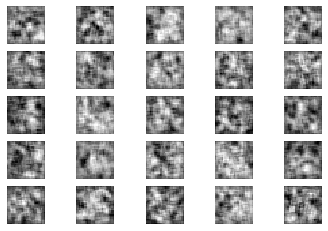

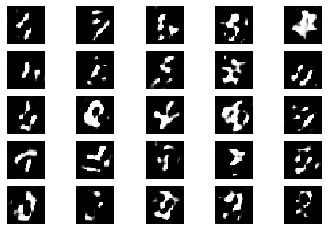

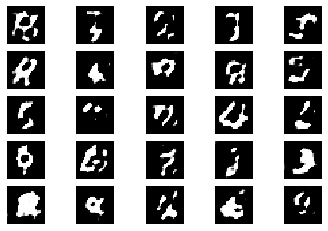

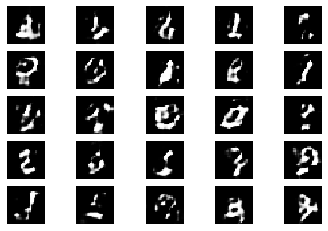

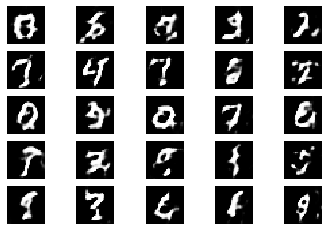

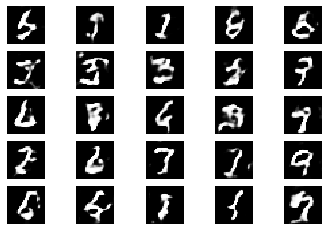

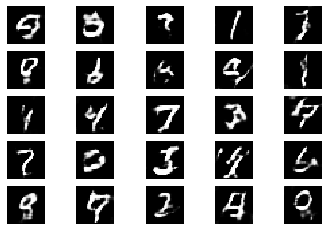

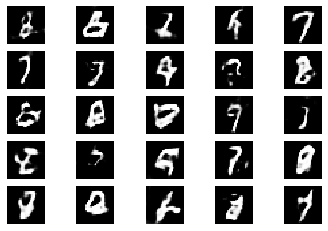

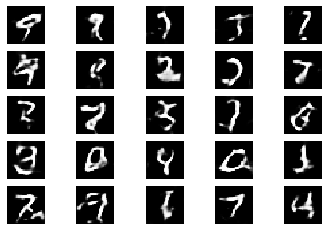

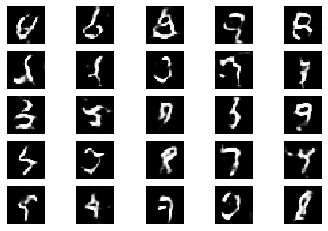

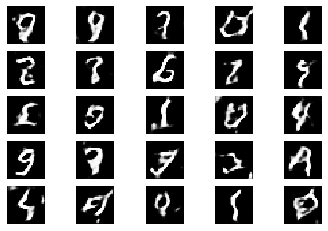

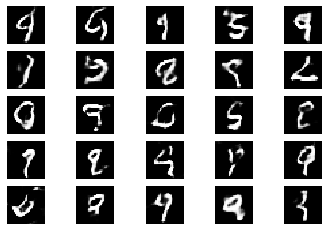

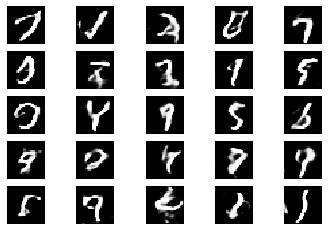

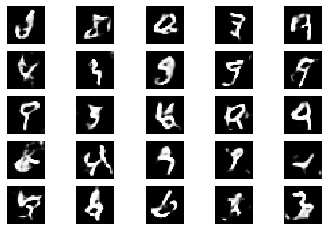

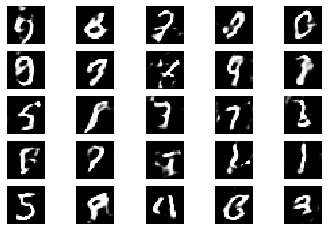

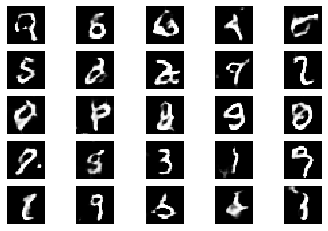

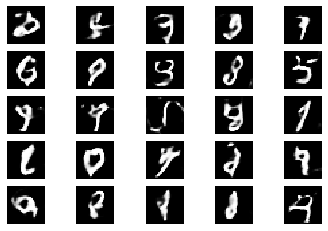

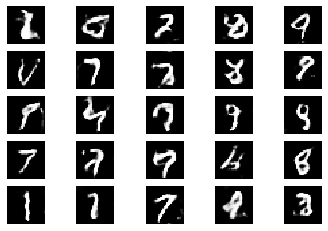

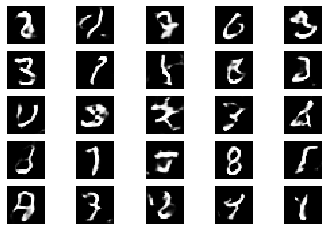

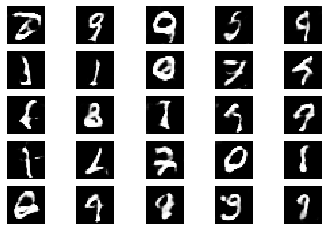

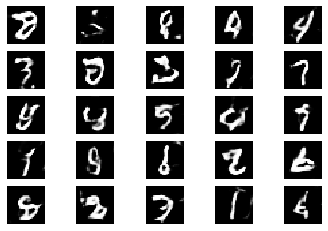

In [17]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt


#생성자
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

#판별자
descriminator = Sequential()
descriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28,28,1), padding = 'same'))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Dropout(0.3))
descriminator.add(Conv2D(128, kernel_size = 5,padding = 'same'))
descriminator.add(LeakyReLU(0.3))
descriminator.add(Flatten())
descriminator.add(Dense(1, activation = 'sigmoid'))
descriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
descriminator.trainable = False

#랜덤하게 설정한 100개의 뉴런을 가진 입력층
ginput = Input(shape = (100,))
dis_output = descriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_,_) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28,28,1).astype('float32')
    x_train = (x_train-127.5)/127.5
    
    for i in range(epoch):
        true = np.ones((batch_size, 1))
        idx = np.random.randint(0,x_train.shape[0], batch_size)
        imgs = x_train[idx]
        #실제 이미지와 1레이블이 붙은 것을 입력받으면 분류기의 분류와 오차 계산
        d_loss_real = descriminator.train_on_batch(imgs, true)
    
        false = np.zeros((batch_size, 1))
        noise = np.random.normal(0,1,(batch_size, 100))
        gen_imgs = generator.predict(noise)
        #생성 이미지와 0레이블이 붙은 것을 입력 받으면 분류기의 분류와 오차 계산
        d_loss_fake = descriminator.train_on_batch(gen_imgs, false)
    
        #d_loss_fake와 d_loss_real을 더한 값의 평균이 판별자의 오차이다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        if i %200 == 0:
            print('epoch:{}, d_loss:{}, g_loss:{}'.format(i, d_loss, g_loss))
    
    
    
        if i % saving_interval == 0:
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
        
            gen_imgs = 0.5*gen_imgs + 0.5
            fig, axs = plt.subplots(5,5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count,:,:,0], cmap = 'gray')
                    axs[j,k].axis('off')
                    count += 1

                
gan_train(4001, 32, 200)